# Imports

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import matplotlib 

import warnings
warnings.filterwarnings('ignore')


In [37]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from keras.layers import Dense, SimpleRNN, LSTM, GRU                                      

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.datasets import get_rdataset

# Load Data

In [39]:
#Monthly Airline Passenger Numbers 1949-1960, in thousands
air_passengers = get_rdataset("AirPassengers")
air_p = air_passengers.data
air_p.index = pd.date_range('1949', '1961', freq='M')
air_p.drop(columns=['time'], inplace=True)
air_p.columns = ['passengers']
air_p

,passengers
1949-01-31,112
1949-02-28,118
1949-03-31,132
1949-04-30,129
1949-05-31,121
1949-06-30,135
1949-07-31,148
1949-08-31,148
1949-09-30,136
1949-10-31,119


### Visualize the time series 

<Axes: title={'center': 'Monthly Passengers'}>

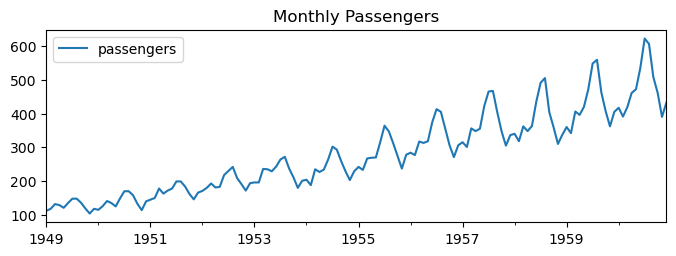

In [40]:
air_p.plot(figsize=(8, 2.5),title='Monthly Passengers')

# Functiones

In [41]:
def creat_laged_features(df, window):
    d = df.values
    x = []
    n = len(df)
    idx = df.index[:-window]
    for start in range(n-window):
        end = start + window
        x.append(d[start:end])
    cols = [f'x_{i}' for i in range(1, window+1)]
    x = np.array(x).reshape(n-window, -1)
    y = df.iloc[window:].values
    df_xs = pd.DataFrame(x, columns=cols, index=idx)
    df_y = pd.DataFrame(y.reshape(-1), columns=['y'], index=idx)
    return pd.concat([df_xs, df_y], axis=1).dropna()

In [42]:
def create_window_features(df, window_size, variables=None):
    """
    Create lagged features for specified variables based on a given window size.
    gets the data frame, the variables to create lagged features as list, and the window size
    if variables is None, use all columns in the dataframe
    """
    if variables is None:
        variables = df.columns

    for variable in variables:
        for lag in range(window_size, 0 , -1): # iterate over the window size in reverse
            lagged_col_name = f"{variable}_time_step -{lag}"
            df[lagged_col_name] = df[variable].shift(lag)
    
    # Drop rows with NaN values introduced by shifting
    df.dropna(inplace=True)
    
    return df

# Preparing data to fit the model

In [43]:
# Select the data set
ts_df= air_p.copy()
# Create lagged features
y_col = 'passengers'
ts_lags= create_window_features(ts_df, window_size=5, variables=[y_col])
# change the name of y_col to y
ts_lags.rename(columns={y_col:'y'}, inplace=True)

print('ts_lags.shape-', ts_lags.shape)
ts_lags.tail()

ts_lags.shape- (139, 6)


,y,passengers_time_step -5,passengers_time_step -4,passengers_time_step -3,passengers_time_step -2,passengers_time_step -1
1960-08-31,606,419.0,461.0,472.0,535.0,622.0
1960-09-30,508,461.0,472.0,535.0,622.0,606.0
1960-10-31,461,472.0,535.0,622.0,606.0,508.0
1960-11-30,390,535.0,622.0,606.0,508.0,461.0
1960-12-31,432,622.0,606.0,508.0,461.0,390.0


##  Scaling and Splitting (Using Scikit-Learn)

In [44]:
# Create the features and target (X, y) for the train, validation, and test data
X_set, y_set = ts_lags.drop('y', axis=1), ts_lags['y']
# convert y_set to 2D dataframe
y_set = y_set.to_frame()

# Split the data into train, validation, and test sets
# When shuffle=False,  train_test_split will split based on the original order last 15% of the rows will be assigned to test)
X_train, X_test, y_train, y_test = train_test_split(X_set, y_set, test_size=0.15, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, shuffle=False)

# Scale the data using StandardScaler (X and y separately)
x_scaler = StandardScaler()
X_train_scaled = x_scaler.fit_transform(X_train) # fit_transform on the training set only
X_val_scaled = x_scaler.transform(X_val)
X_test_scaled = x_scaler.transform(X_test)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_val_scaled = y_scaler.transform(y_val)
y_test_scaled = y_scaler.transform(y_test)

### Reshape X data to 3D to fit RNN input shape

In [45]:
X_train_scaled.shape

(100, 5)

In [46]:
# Convert x_train x_test and x_val to NumPy array with dimension to fit the RNN input shape (samples, timesteps, features)
x_train_RNN_array = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
x_test_RNN_array = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)
x_val_RNN_array = X_val_scaled.reshape(X_val_scaled.shape[0], X_val_scaled.shape[1], 1)
print('x_train_RNN_array.shape:', x_train_RNN_array.shape, 'x_test_RNN_array.shape:', x_test_RNN_array.shape, 'x_val_RNN_array.shape:', x_val_RNN_array.shape)

x_train_RNN_array.shape: (100, 5, 1) x_test_RNN_array.shape: (21, 5, 1) x_val_RNN_array.shape: (18, 5, 1)


# Simple RNN

In [47]:
keras.backend.clear_session()

## Create Model 

In [48]:
def create_RNN_model(x_train, units):
    model = keras.Sequential()
    # RNNs Expect Input Data in 3D Shape: (samples=batch size, timesteps, features)
    model.add(SimpleRNN(units=units, return_sequences=False, input_shape=(x_train.shape[1],x_train.shape[2])))
    model.add(Dense(1)) # output layer predicting a single numerical value
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[RootMeanSquaredError(), MeanAbsoluteError()])
    return model

In [49]:
simple_RNN= create_RNN_model(x_train=x_train_RNN_array, units= 32)
simple_RNN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 32)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,121 (4.38 KB)

 Trainable params: 1,121 (4.38 KB)

 Non-trainable params: 0 (0.00 B)

## Train Model and Predict

### Training the model

In [50]:
history = simple_RNN.fit(x_train_RNN_array, y_train_scaled , epochs=50, batch_size=32, 
                            validation_data=(x_val_RNN_array, y_val_scaled), verbose=1)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.8055 - mean_absolute_error: 0.7056 - root_mean_squared_error: 0.8948 - val_loss: 2.1043 - val_mean_absolute_error: 1.1851 - val_root_mean_squared_error: 1.4506
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6662 - mean_absolute_error: 0.6195 - root_mean_squared_error: 0.8137 - val_loss: 1.3743 - val_mean_absolute_error: 0.8743 - val_root_mean_squared_error: 1.1723
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4408 - mean_absolute_error: 0.5010 - root_mean_squared_error: 0.6630 - val_loss: 0.9945 - val_mean_absolute_error: 0.6846 - val_root_mean_squared_error: 0.9973
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3455 - mean_absolute_error: 0.4598 - root_mean_squared_error: 0.5851 - val_loss: 0.8342 - val_mean_absolute_error: 0.6369 - val_root_mean_squared_error: 0.9133
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3314 - mean_absolute_error: 0.4499 - root_mean_squared_error: 0.5731 

### Evaluate Training

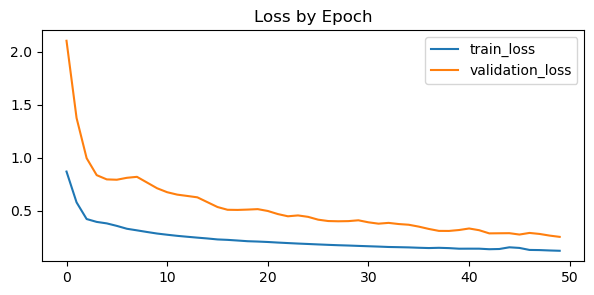

In [51]:
# Plot the loss by epoch of train and validation data
plt.figure(figsize=(7, 3))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.legend()
plt.title('Loss by Epoch')
plt.show()

### Evaluate prediction on the test set

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


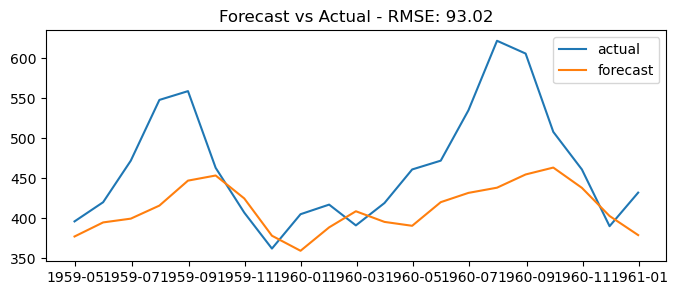

In [52]:
y_pred_scaled= simple_RNN.predict(x_test_RNN_array)
# inverse transform the scaled y values to the original scale
y_pred= y_scaler.inverse_transform(y_pred_scaled)
y_pred= pd.Series(y_pred.flatten(), index=y_test.index)

# evaluate the model eror 
rmse = np.sqrt(np.mean((y_test.values - y_pred.values)**2))

# Plot the forecast vs actual
time_index= y_test.index
plt.figure(figsize=(8, 3))
plt.plot(time_index, y_test, label='actual')
plt.plot(time_index, y_pred, label='forecast')
# print the RMSE on the plot
plt.title(f'Forecast vs Actual - RMSE: {rmse:.2f}')
plt.legend()
plt.show()


# LSTM (Long Short Term Memory)

In [53]:
keras.backend.clear_session()

## Create Model

In [54]:
def create_LSTM_model(x_train, units):
    model = keras.Sequential()
    model.add(LSTM(units=units, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[RootMeanSquaredError(), MeanAbsoluteError()])
    return model

In [55]:
simple_LSTM= create_LSTM_model(x_train=x_train_RNN_array, units=16)
simple_LSTM.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 16)             │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           170 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,333 (5.21 KB)

 Trainable params: 1,333 (5.21 KB)

 Non-trainable params: 0 (0.00 B)

## Train Model and Predict

In [56]:
history = simple_LSTM.fit(x_train_RNN_array, y_train_scaled , epochs=50, batch_size=32, 
                            validation_data=(x_val_RNN_array, y_val_scaled), verbose=1)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 1.1565 - mean_absolute_error: 0.8466 - root_mean_squared_error: 1.0749 - val_loss: 4.2100 - val_mean_absolute_error: 1.9425 - val_root_mean_squared_error: 2.0518
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9387 - mean_absolute_error: 0.7664 - root_mean_squared_error: 0.9665 - val_loss: 3.9221 - val_mean_absolute_error: 1.8666 - val_root_mean_squared_error: 1.9804
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9227 - mean_absolute_error: 0.7387 - root_mean_squared_error: 0.9598 - val_loss: 3.7267 - val_mean_absolute_error: 1.8149 - val_root_mean_squared_error: 1.9305
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9106 - mean_absolute_error: 0.7406 - root_mean_squared_error: 0.9541 - val_loss: 3.5637 - val_mean_absolute_error: 1.7707 - val_root_mean_squared_error: 1.8878
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8730 - mean_absolute_error: 0.7028 - root_mean_squared_error: 0.9338 

### Evaluate the training

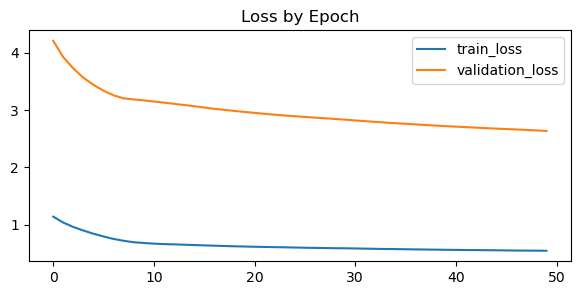

In [57]:
# Plot the loss by epoch of train and validation data
plt.figure(figsize=(7, 3))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.legend()
plt.title('Loss by Epoch')
plt.show()

### Evaluate Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


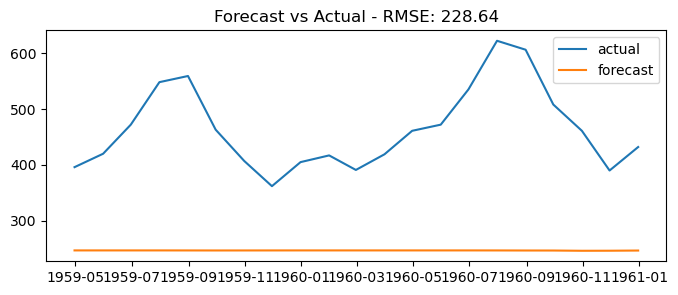

In [58]:
y_pred_scaled= simple_LSTM.predict(x_test_RNN_array)
# inverse transform the scaled y values to the original scale
y_pred= y_scaler.inverse_transform(y_pred_scaled)
y_pred= pd.Series(y_pred.flatten(), index=y_test.index)

# evaluate the model eror 
rmse = np.sqrt(np.mean((y_test.values - y_pred.values)**2))

# Plot the forecast vs actual
time_index= y_test.index
plt.figure(figsize=(8, 3))
plt.plot(time_index, y_test, label='actual')
plt.plot(time_index, y_pred, label='forecast')
# print the RMSE on the plot
plt.title(f'Forecast vs Actual - RMSE: {rmse:.2f}')
plt.legend()
plt.show()


# GRU Gated Recurrent Unit

In [59]:
keras.backend.clear_session()

## Create Model 

In [60]:
def create_GRU_model(x_train, units):
    model = keras.Sequential()
    # RNNs Expect Input Data in 3D Shape: (samples=batch size, timesteps, features)
    model.add(GRU(units=units, return_sequences=False, input_shape=(x_train.shape[1],x_train.shape[2])))
    model.add(Dense(1)) # output layer predicting a single numerical value

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[RootMeanSquaredError(), MeanAbsoluteError()])
    return model

In [61]:
simple_GRU= create_GRU_model(x_train=x_train_RNN_array, units= 32)
simple_GRU.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 32)             │         3,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,393 (13.25 KB)

 Trainable params: 3,393 (13.25 KB)

 Non-trainable params: 0 (0.00 B)

## Train Model and Predict

### Training the model

In [62]:
history = simple_GRU.fit(x_train_RNN_array, y_train_scaled , epochs=50, batch_size=32, 
                            validation_data=(x_val_RNN_array, y_val_scaled), verbose=1)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.6431 - mean_absolute_error: 0.6555 - root_mean_squared_error: 0.8009 - val_loss: 1.7720 - val_mean_absolute_error: 1.1665 - val_root_mean_squared_error: 1.3312
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5242 - mean_absolute_error: 0.5749 - root_mean_squared_error: 0.7231 - val_loss: 1.4843 - val_mean_absolute_error: 1.0344 - val_root_mean_squared_error: 1.2183
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4593 - mean_absolute_error: 0.5355 - root_mean_squared_error: 0.6769 - val_loss: 1.2250 - val_mean_absolute_error: 0.8975 - val_root_mean_squared_error: 1.1068
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4463 - mean_absolute_error: 0.5301 - root_mean_squared_error: 0.6662 - val_loss: 1.0055 - val_mean_absolute_error: 0.7941 - val_root_mean_squared_error: 1.0028
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3442 - mean_absolute_error: 0.4642 - root_mean_squared_error: 0.5866 

### Evaluate Training

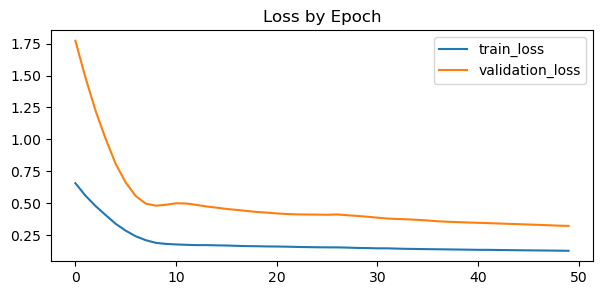

In [63]:
# Plot the loss by epoch of train and validation data
plt.figure(figsize=(7, 3))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.legend()
plt.title('Loss by Epoch')
plt.show()

### Evaluate prediction on the test set

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


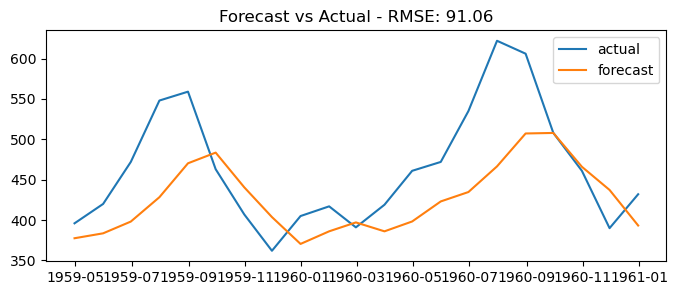

In [64]:
y_pred_scaled= simple_GRU.predict(x_test_RNN_array)
# inverse transform the scaled y values to the original scale
y_pred= y_scaler.inverse_transform(y_pred_scaled)
y_pred= pd.Series(y_pred.flatten(), index=y_test.index)

# evaluate the model eror 
rmse = np.sqrt(np.mean((y_test.values - y_pred.values)**2))

# Plot the forecast vs actual
time_index= y_test.index
plt.figure(figsize=(8, 3))
plt.plot(time_index, y_test, label='actual')
plt.plot(time_index, y_pred, label='forecast')
# print the RMSE on the plot
plt.title(f'Forecast vs Actual - RMSE: {rmse:.2f}')
plt.legend()
plt.show()
